<a href="https://colab.research.google.com/github/tlohde/sense_GEE/blob/main/SENSE_2020_GEE/3_Classification__forProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import earthengine API
import ee
# Authenticate and initialise 
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWjqi9abjlnXAKs0O0_DrwxD8KU0vl8q8GwzeYX8_Wr_lGljWjQsRfc

Successfully saved authorization token.


In [118]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

#!pip install geehydro # Life saver for plotting GEE stuff with Python!
import geehydro
import folium

#import subprocess

import geemap
geemap.Initialize()
import wxee
wxee.Initialize()

import pprint


AttributeError: module 'geemap' has no attribute 'Initialize'

Number of images in collection:  4

<DatetimeArray>
['2020-05-06 12:10:44.746000', '2020-05-22 12:10:46.579000',
 '2020-06-07 12:10:54.140000', '2020-06-23 12:11:03.228000']
Length: 4, dtype: datetime64[ns]


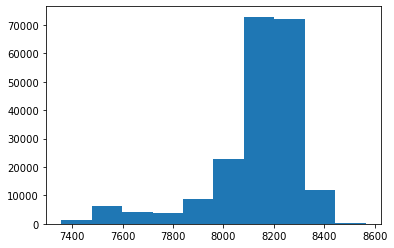

In [126]:
lon = -4.248941
lat = 49.852876

# collection of landsat8 images between dates at point of interest
l8_col = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-05-01','2020-07-31').filter(ee.Filter.eq('WRS_PATH', 204)).filter(ee.Filter.eq('WRS_ROW',25))

# filter(ee.Filter.eq('WRS_PATH', 44))
#   .filter(ee.Filter.eq('WRS_ROW', 34));


# 204, 025 : path, row

# Get the number of images.
count = l8_col.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get the date range of images in the collection.

# range = l8_col.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
#print('Date range: ', str(ee.Date(range.get('min')).getInfo()), str(ee.Date(range.get('max')).getInfo())+'\n')

##### get dates ofeach image

dates = l8_col.getArray("system:time_start")

point = ee.Geometry.Point(-4.248941, 49.852876)

# Get info from the point

info = l8_col.getRegion(point,30).getInfo() # change colelction by series
# print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = pd.array([datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int64))])
#print(time)
# june23 = l8_col.filterDate('2020-06-23').first()
june23 = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-06-21','2020-06-25').first()

june23_rgb = june23.select(['B4','B3','B2'])

# Image(url=june23.getThumbUrl({'min': 0, 'max': 30000, 'bands':['B4','B3','B2'],'dimensions': 512}))

small_aoi = ee.Geometry.Polygon(
    [[-4.4250233, 50.097365],
      [-4.4332587,50.0885514],
      [-4.4250233,49.9985597],
      [-4.2136499,50.005624],
      [-4.1999243,50.0956024],
      [-4.4250233,50.097365]])

# sample the specific band from image, and convert to 2d array
band_arrs = june23_rgb.sampleRectangle(region = small_aoi)
#print(band_arrs)
b4 = band_arrs.get('B4')
nparr_b4 = np.array(b4.getInfo())

#print(b4)
# flatten to 1d and get histogram of band

plt.hist(nparr_b4.flatten())


# a bigger polygon
aoi = ee.Geometry.Polygon(
    [[-4.9438477, 50.1274176],
    [-5.0372314, 49.9509678],
    [-5.2459717, 49.9226757],
    [-5.4492188, 50.0569155],
    [-5.8007813, 49.9792434],
    [-6.5808105, 49.2709504],
    [-5.3833008, 48.5487028],
    [-4.7845459, 48.6322928],
    [-3.1695557, 48.9472309],
    [-2.6147461, 49.6246044],
    [-2.5817871, 49.8837468],
    [-2.7410889, 50.4923579],
    [-3.3453369, 50.4783735],
    [-3.4387207, 50.3067287],
    [-3.5925293, 50.2013332],
    [-3.7188721, 50.1555894],
    [-3.9331055, 50.2294615],
    [-4.2626953, 50.2926894],
    [-4.4769287, 50.2856682],
    [-4.6911621, 50.2575731],
    [-4.7625732, 50.1942985],
    [-4.9438477, 50.1274176]])


print(time)

In [129]:
#### sentinel 3

s3_col = ee.ImageCollection("COPERNICUS/S3/OLCI").filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-05-01','2020-07-31')
count = s3_col.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get info from the point

info = s3_col.getRegion(point,30).getInfo() # change colelction by series
# print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = pd.array([datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int64))])
print(time)

s3_map = folium.Map(location = [50.00,-4.2,],zoom_start=6)
masked_list = ee.List([])

for i in arange(2):
    t = time[i]
    tlab = t.strftime('%d%m%Y')
    tplus1 = (t + pd.DateOffset(1)).strftime('%Y-%m-%d')
    tminus1 = (t + pd.DateOffset(-1)).strftime('%Y-%m-%d')
    
    img = s3_col.filterDate(tminus1,tplus1).first().select('Oa03_radiance').multiply(0.0121481)
    img = img.clip(aoi)
#     masked = maskIn(img, aoi)
#     masked_list = masked_list.add(masked)
    s3_map.addLayer(img, {'bands' :['Oa03_radiance'], 'max': 1, 'min':-1}, tlab)
    
masked_col = ee.ImageCollection(masked_list)

def maskIn (img, geo):
    mask = ee.Image.constant(1).clip(geo).mask()
    img = img.updateMask(mask)
    return img

masked = maskIn(img, aoi)

s3_map.addLayer(small_aoi)#
#s3_map.addLayer(s3_col.first(),{},'masked')
folium.LayerControl().add_to(s3_map)
s3_map


Number of images in collection:  135

<DatetimeArray>
['2020-05-01 12:13:00', '2020-05-02 11:46:49', '2020-05-03 11:20:39',
 '2020-05-05 12:09:16', '2020-05-06 11:43:05', '2020-05-07 11:16:54',
 '2020-05-09 12:05:32', '2020-05-10 11:39:21', '2020-05-11 11:13:10',
 '2020-05-13 12:01:47',
 ...
 '2020-07-17 11:37:17', '2020-07-18 11:11:07', '2020-07-20 11:59:44',
 '2020-07-21 11:33:33', '2020-07-22 11:07:22', '2020-07-24 11:55:59',
 '2020-07-25 11:29:48', '2020-07-26 11:03:37', '2020-07-28 11:52:15',
 '2020-07-29 11:26:04']
Length: 135, dtype: datetime64[ns]


In [135]:
import geemap.chart as chart
masked_col
count = masked_col.size()
print(count.getInfo())

# arr = s3_col.wx.to_xarray(scale=300)

my_sample = s3_col.first().sample(aoi, 5000)

chart.feature_histogram(my_sample, 'Oa03_radiance')



0


None


In [ ]:
## band ratio methods
###,

# add ndwi band fucntion
def ndwi_func (img):
#     ndwiOut = img.normalizedDifference(['B3','B5'])
#     water = ndwi.gt(0)
#     img.updateMask(water)    
    return img.addBands(img.normalizedDifference(['B3','B5']).rename('NDWI'))

# add band mask function 
def mask_func (img):
    ndwi = img.select(['NDWI'])
    water = ndwi.gt(0)
    img = img.updateMask(water)
    return img

def br_func (img):   
        
    ndwi = img.normalizedDifference(['B3','B5'])
    water = ndwi.gt(0)
    img = img.updateMask(water)    
    
    b2 = img.select('B2')
    b3 = img.select('B3')
    b4 = img.select('B4')
    b5 = img.select('B5')
       
    
    twobda = b2.divide(b4)
    threebda = (b2.subtract(b4)).divide(b3)
    ndci = (b5.subtract(b4)).divide(b5.add(b4))
    
    return img.addBands(twobda.rename('twobda')).addBands(threebda.rename('threebda')).addBands(ndci.rename('ndci'))

br_col = l8_col.map(br_func).map(a)

# print(br_col.first().bandNames().getInfo())

#### create map
brMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)
# add layers

brMap.addLayer(br_col.first(), {'bands': ['ndci'], 'min':-1, 'max':1}, 'ndci')
# add layer control and view map
folium.LayerControl().add_to(brMap)
brMap


In [ ]:
brMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)

for i in arange(len(time)):
    t = time[i]
    tlab = t.strftime('%d%m%Y')
    tplus1 = (t + pd.DateOffset(1)).strftime('%Y-%m-%d')
    tminus1 = (t + pd.DateOffset(-1)).strftime('%Y-%m-%d')
    
    img = br_col.filterDate(tminus1,tplus1).first()
    brMap.addLayer(img, {'bands': ['ndci'], 'min':-1, 'max':1}, tlab)
    
folium.LayerControl().add_to(brMap)
brMap

In [ ]:
############# 
# create ndwi function for mapping to image collection #####
#############

# add ndwi band fucntion
def ndwi_func (img):
#     ndwiOut = img.normalizedDifference(['B3','B5'])
#     water = ndwi.gt(0)
#     img.updateMask(water)    
    return img.addBands(img.normalizedDifference(['B3','B5']).rename('NDWI'))

# add band mask function 
def mask_func (img):
    ndwi = img.select(['NDWI'])
    water = ndwi.gt(0)
    img = img.updateMask(water)
    return img

def apply_clust (img):
    clustered = img.cluster(clusterer)
    return img.addBands(clustered.rename('cluster'))
    
# map ndwi and mask function to image collection
ndwi_col = l8_col.map(ndwi_func).map(mask_func).map(apply_clust)

print(ndwi_col.first().bandNames().getInfo())


clMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)

for i in arange(len(time)):
    t = time[i]
    tlab = t.strftime('%d-%m-%Y')
    tplus1 = (t + pd.DateOffset(1)).strftime('%Y-%m-%d')
    tminus1 = (t + pd.DateOffset(-1)).strftime('%Y-%m-%d')
    
    img = ndwi_col.filterDate(tminus1,tplus1).first()
    clust = img.select('cluster')
    clMap.addLayer(clust.randomVisualizer(), {}, tlab)
    clMap.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, (tlab+'landsat'))
    
folium.LayerControl().add_to(clMap)
clMap




In [ ]:
##### create land mask ####

# ndwi 
ndwi = june23.normalizedDifference(['B3', 'B5']) # green and NIR

# Create binary image - water vs. not water
water = ndwi.gt(0) # from McFeeters (1996)

# mask landsat image
june23_masked = june23.updateMask(water)

#### create map
maskMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)
# add layers
maskMap.addLayer(water,{'min':0, 'max':1},'water')
maskMap.addLayer(june23_masked, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'masked landsat image')
# add layer control and view map
folium.LayerControl().add_to(maskMap)
maskMap

In [37]:
# not necessary to define region - as if unpecified defaults to whole image footprint

# Make the training dataset.
training = june23_masked.sample(scale= 30,  numPixels= 5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(3).train(training)

# Cluster the input using the trained clusterer.
result_june23 = june23_masked.cluster(clusterer)
#result_may15 = may15.cluster(clusterer)

# Display the clusters with random colors.

resultsMap = folium.Map(location = [50.00,-4.2,],zoom_start=9)
resultsMap.addLayer(result_june23.randomVisualizer(), {}, 'june23_clusters')
#resultsMap.addLayer(result_may15.randomVisualizer(), {}, 'may15_clusters')
resultsMap.addLayer(june23, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'june23')
#resultsMap.addLayer(may15, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'may15')
boundary = result_june23.propertyNames()
folium.LayerControl().add_to(resultsMap)
resultsMap

print(boundary)


ee.List({
  "functionInvocationValue": {
    "functionName": "Element.propertyNames",
    "arguments": {
      "element": {
        "functionInvocationValue": {
          "functionName": "Image.cluster",
          "arguments": {
            "clusterer": {
              "functionInvocationValue": {
                "functionName": "Clusterer.train",
                "arguments": {
                  "clusterer": {
                    "functionInvocationValue": {
                      "functionName": "Clusterer.wekaKMeans",
                      "arguments": {
                        "nClusters": {
                          "constantValue": 3
                        }
                      }
                    }
                  },
                  "features": {
                    "functionInvocationValue": {
                      "functionName": "Image.sample",
                      "arguments": {
                        "image": {
                          "functionInvocationValue": {

In [44]:
import os
out_dir = os.getcwd()
# out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
outputstats = os.path.join(out_dir, 'outputstats.csv')  

geemap.zonal_statistics(result_june23, result_june23.geometry(), outputstats, statistics_type='MAX')

The input zone data must be an ee.FeatureCollection.


ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Image.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Image.cluster",
          "arguments": {
            "clusterer": {
              "functionInvocationValue": {
                "functionName": "Clusterer.train",
                "arguments": {
                  "clusterer": {
                    "functionInvocationValue": {
                      "functionName": "Clusterer.wekaKMeans",
                      "arguments": {
                        "nClusters": {
                          "constantValue": 3
                        }
                      }
                    }
                  },
                  "features": {
                    "functionInvocationValue": {
                      "functionName": "Image.sample",
                      "arguments": {
                        "image": {
                          "functionInvocationValue": {
  